In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECE_ML&DNN/final_project') # change work direcotry
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ECE_ML&DNN/final_project


In [2]:
import os
from PIL import Image, ImageFilter, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg19
import numpy as np

import random

from torch.autograd import Variable
import torchvision.transforms as transforms

from torchvision.utils import save_image

import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import shutil
import cv2
from tqdm import tqdm

In [ ]:

# image_folder = "sharp_face_data_all"


# jpg_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]


# images = {}


# for file in jpg_files:
#     file_path = os.path.join(image_folder, file)
#     try:

#         image = Image.open(file_path)
#         images[file] = image
#         print(f"Loaded image: {file}")
#     except Exception as e:
#         print(f"Error loading image {file}: {e}")


# print(f"Total images loaded: {len(images)}")


In [ ]:
# # Define folders
# image_folder = "sharp_face_data_all"
# sharp_train_folder = "sharp_face_data_train"
# sharp_test_folder = "sharp_face_data_test"
# blurred_train_folder = "blurred_face_data_train"
# blurred_test_folder = "blurred_face_data_test"

# # Create output folders if they don't exist
# os.makedirs(sharp_train_folder, exist_ok=True)
# os.makedirs(sharp_test_folder, exist_ok=True)
# os.makedirs(blurred_train_folder, exist_ok=True)
# os.makedirs(blurred_test_folder, exist_ok=True)

# # Get all jpg files
# jpg_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# # Shuffle and split data
# random.shuffle(jpg_files)
# split_index = int(0.8 * len(jpg_files))  # 80% train, 20% test
# train_files = jpg_files[:split_index]
# test_files = jpg_files[split_index:]

# def save_images(file_list, sharp_folder, blurred_folder):
#     file_list = sorted(file_list)  # Sort files to maintain order
#     for file in file_list:
#         file_path = os.path.join(image_folder, file)
#         try:
#             # Open, adjust orientation, and save sharp image
#             sharp_image = Image.open(file_path)
#             sharp_image = ImageOps.exif_transpose(sharp_image)  # Adjust orientation based on EXIF
#             sharp_image.save(os.path.join(sharp_folder, file))

#             # Create and save blurred image
#             blurred_image = sharp_image.filter(ImageFilter.GaussianBlur(radius=20))  # Adjust radius as needed
#             blurred_image.save(os.path.join(blurred_folder, file))

#             print(f"Processed image: {file}")
#         except Exception as e:
#             print(f"Error processing image {file}: {e}")

# # Save train and test images
# save_images(train_files, sharp_train_folder, blurred_train_folder)
# save_images(test_files, sharp_test_folder, blurred_test_folder)


Processed image: 0.jpg
Processed image: 1.jpg
Processed image: 10.jpg
Processed image: 100 copy.jpg
Processed image: 101 copy.jpg
Processed image: 101.jpg
Processed image: 102.jpg
Processed image: 103 copy.jpg
Processed image: 103.jpg
Processed image: 104 copy.jpg
Processed image: 104.jpg
Processed image: 105 copy.jpg
Processed image: 105.jpg
Processed image: 106 copy.jpg
Processed image: 106.jpg
Processed image: 107 copy.jpg
Processed image: 107.jpg
Processed image: 108 copy.jpg
Processed image: 108.jpg
Processed image: 109.jpg
Processed image: 11 copy.jpg
Processed image: 11.jpg
Processed image: 12.jpg
Processed image: 13 copy.jpg
Processed image: 14 copy.jpg
Processed image: 14.jpg
Processed image: 15 copy.jpg
Processed image: 16 copy.jpg
Processed image: 16.jpg
Processed image: 17 copy.jpg
Processed image: 18 copy.jpg
Processed image: 18.jpg
Processed image: 19.jpg
Processed image: 2.jpg
Processed image: 20 copy.jpg
Processed image: 20.jpg
Processed image: 21 copy.jpg
Processed ima

In [10]:
d_losses = []
g_losses = []


# Dataset for Paired Images
class PairedDataset(Dataset):
    def __init__(self, sharp_folder, blurred_folder, transform=None):
        self.sharp_folder = sharp_folder
        self.blurred_folder = blurred_folder
        self.transform = transform

        # Ensure filenames are sorted for correspondence
        self.filenames = sorted(os.listdir(sharp_folder))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        sharp_image_path = os.path.join(self.sharp_folder, self.filenames[idx])
        blurred_image_path = os.path.join(self.blurred_folder, self.filenames[idx])

        sharp_image = Image.open(sharp_image_path).convert("RGB")
        blurred_image = Image.open(blurred_image_path).convert("RGB")

        if self.transform:
            sharp_image = self.transform(sharp_image)
            blurred_image = self.transform(blurred_image)

        return blurred_image, sharp_image


# ResnetBlock
class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer, use_dropout):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            norm_layer(dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            norm_layer(dim),
        )

    def forward(self, x):
        return x + self.block(x)


# ResnetGenerator
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(ResnetGenerator, self).__init__()
        model = [
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3, bias=False),
            norm_layer(ngf),
            nn.ReLU(inplace=True),
        ]
        for _ in range(2):
            model += [
                nn.Conv2d(ngf, ngf * 2, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(ngf * 2),
                nn.ReLU(inplace=True),
            ]
            ngf *= 2
        for _ in range(n_blocks):
            model += [ResnetBlock(ngf, norm_layer, use_dropout)]
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(ngf, ngf // 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                norm_layer(ngf // 2),
                nn.ReLU(inplace=True),
            ]
            ngf //= 2
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# PatchGANDiscriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        layers = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        for i in range(1, n_layers):
            mult = 2 ** (i - 1)
            layers += [
                nn.Conv2d(ndf * mult, ndf * mult * 2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(ndf * mult * 2),
                nn.LeakyReLU(0.2, inplace=True),
            ]
        layers += [nn.Conv2d(ndf * mult * 2, 1, kernel_size=4, padding=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# PerceptualLoss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:15].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, fake, real):
        fake_features = self.vgg(fake)
        real_features = self.vgg(real).detach()
        return nn.functional.mse_loss(fake_features, real_features)


# Train DeblurGAN
def train_deblurgan(generator, discriminator, dataloader, device, epochs=100, lr=0.0001):
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    adversarial_loss = nn.BCEWithLogitsLoss()
    perceptual_loss = PerceptualLoss().to(device)

    # d_losses = []
    # g_losses = []

    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        for i, (blurred, sharp) in enumerate(dataloader):
            blurred, sharp = blurred.to(device), sharp.to(device)

            # Train Discriminator
            fake = generator(blurred)
            real_pred = discriminator(sharp)
            fake_pred = discriminator(fake.detach())
            d_loss = (adversarial_loss(real_pred, torch.ones_like(real_pred, device=device)) +
                      adversarial_loss(fake_pred, torch.zeros_like(fake_pred, device=device))) / 2
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            fake_pred = discriminator(fake)
            g_adv_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred, device=device))
            g_perceptual_loss = perceptual_loss(fake, sharp)
            g_loss = g_adv_loss + 10 * g_perceptual_loss
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

            if i == 0 or i == 10:
              print(f"Epoch {epoch+1}/{epochs}, Step {i + 1}/{len(dataloader)}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        d_losses.append(epoch_d_loss / len(dataloader))
        g_losses.append(epoch_g_loss / len(dataloader))

        # Save sample results
        if epoch % 10 == 0:
            save_image(fake, f"deblurred_results/sample_epoch_{epoch}.png")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), d_losses, label="D Loss", marker='o')
    plt.plot(range(1, epochs + 1), g_losses, label="G Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Discriminator and Generator Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()


# Evaluate Model
def evaluate_model(generator, test_dataloader, device):
    generator.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for i, (blurred, sharp) in enumerate(test_dataloader):
            blurred = blurred.to(device)
            sharp = sharp.to(device)

            restored = generator(blurred)
            restored = denormalize(restored).cpu().numpy()
            sharp = denormalize(sharp).cpu().numpy()

            restored = np.transpose(restored[0], (1, 2, 0))
            sharp = np.transpose(sharp[0], (1, 2, 0))

            psnr_value = psnr(sharp, restored, data_range=restored.max() - restored.min())
            ssim_value = ssim(sharp, restored, multichannel=True, data_range=restored.max() - restored.min(), win_size=3)

            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim


# Denormalize Images
def denormalize(tensor):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)


# Test DeblurGAN
def test_deblurgan(generator, dataloader, device):
    if os.path.exists("evaluation_results"):
      shutil.rmtree("evaluation_results")
    generator.eval()
    os.makedirs("evaluation_results", exist_ok=True)

    with torch.no_grad():
        for i, (blurred, _) in enumerate(dataloader):
            blurred = blurred.to(device)
            restored = generator(blurred)
            restored = denormalize(restored)
            save_image(restored, f"evaluation_results/restored_{i}.png")
    print("Evaluation completed!")


# Main Function
if __name__ == "__main__":
    sharp_train_folder = "sharp_face_data_train"
    sharp_test_folder = "sharp_face_data_test"
    blurred_train_folder = "blurred_face_data_train"
    blurred_test_folder = "blurred_face_data_test"
    batch_size = 16
    epochs = 200
    device = "cuda" if torch.cuda.is_available() else "cpu"

    generator = ResnetGenerator(input_nc=3, output_nc=3).to(device)
    discriminator = PatchGANDiscriminator(input_nc=3).to(device)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    train_dataset = PairedDataset(sharp_train_folder, blurred_train_folder, transform)
    test_dataset = PairedDataset(sharp_test_folder, blurred_test_folder, transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    train_deblurgan(generator, discriminator, train_dataloader, device, epochs=epochs)
    test_deblurgan(generator, test_dataloader, device)
    evaluate_model(generator, test_dataloader, device)

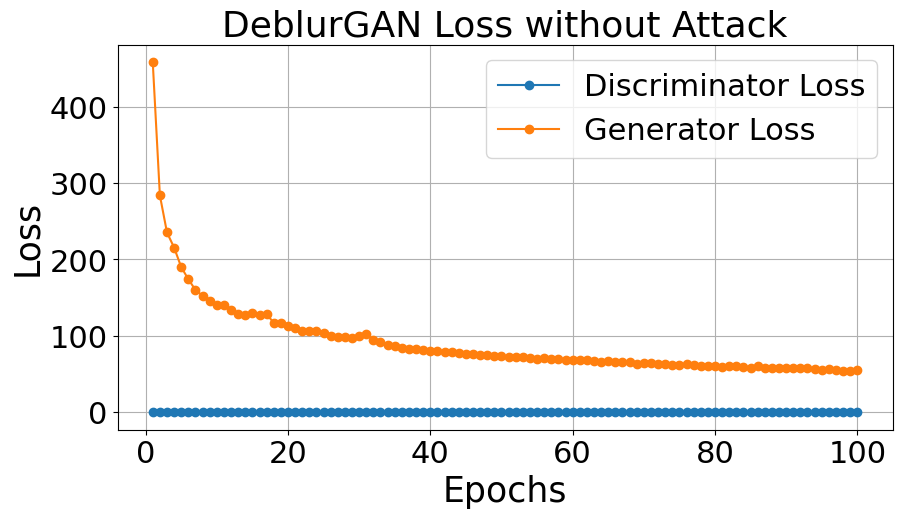

In [ ]:

import numpy as np
steps_per_epoch = 300

max_epoch = 100


plt.figure(figsize=(10, 5))

d_losses_100 = d_losses[:100]
g_losses_100 = g_losses[:100]


plt.plot(range(1, max_epoch + 1), d_losses_100, label="Discriminator Loss", marker='o')
plt.plot(range(1, max_epoch + 1), g_losses_100, label="Generator Loss", marker='o')


plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Loss", fontsize=25)
plt.title("DeblurGAN Loss without Attack", fontsize=26)
plt.legend(fontsize=22)

plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=22)

plt.savefig("loss_plot_no_attack.png")

plt.show()



# Add Mosaic Attack

In [ ]:

# # Parameters
# input_folder = "blurred_face_data_train"
# output_folder = "blurred_face_data_train_mosaic"
# mosaic_level = 70

# # Create the output directory if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Function to apply mosaic to an image
# def apply_mosaic(image, mosaic_level):
#     # Get the dimensions of the image
#     height, width = image.shape[:2]

#     # Resize down to create the mosaic effect
#     small = cv2.resize(image, (max(1, width // mosaic_level), max(1, height // mosaic_level)), interpolation=cv2.INTER_LINEAR)

#     # Resize back to original dimensions
#     mosaic_image = cv2.resize(small, (width, height), interpolation=cv2.INTER_NEAREST)
#     return mosaic_image

# # Process all images in the folder
# for file_name in tqdm(os.listdir(input_folder)):
#     # Construct full file path
#     input_path = os.path.join(input_folder, file_name)
#     output_path = os.path.join(output_folder, file_name)

#     # Read the image
#     image = cv2.imread(input_path)
#     if image is None:
#         print(f"Warning: Unable to read {input_path}. Skipping...")
#         continue

#     # Apply the mosaic effect
#     mosaic_image = apply_mosaic(image, mosaic_level)

#     # Save the processed image
#     cv2.imwrite(output_path, mosaic_image)

# print(f"All images have been processed and saved to {output_folder}.")

100%|██████████| 176/176 [00:13<00:00, 13.04it/s]

All images have been processed and saved to blurred_face_data_train_mosaic.


In [ ]:

# # Parameters
# input_folder = "blurred_face_data_test"
# output_folder = "blurred_face_data_test_mosaic"
# mosaic_level = 70

# # Create the output directory if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Function to apply mosaic to an image
# def apply_mosaic(image, mosaic_level):
#     # Get the dimensions of the image
#     height, width = image.shape[:2]

#     # Resize down to create the mosaic effect
#     small = cv2.resize(image, (max(1, width // mosaic_level), max(1, height // mosaic_level)), interpolation=cv2.INTER_LINEAR)

#     # Resize back to original dimensions
#     mosaic_image = cv2.resize(small, (width, height), interpolation=cv2.INTER_NEAREST)
#     return mosaic_image

# # Process all images in the folder
# for file_name in tqdm(os.listdir(input_folder)):
#     # Construct full file path
#     input_path = os.path.join(input_folder, file_name)
#     output_path = os.path.join(output_folder, file_name)

#     # Read the image
#     image = cv2.imread(input_path)
#     if image is None:
#         print(f"Warning: Unable to read {input_path}. Skipping...")
#         continue

#     # Apply the mosaic effect
#     mosaic_image = apply_mosaic(image, mosaic_level)

#     # Save the processed image
#     cv2.imwrite(output_path, mosaic_image)

# print(f"All images have been processed and saved to {output_folder}.")

100%|██████████| 44/44 [00:03<00:00, 13.26it/s]

All images have been processed and saved to blurred_face_data_test_mosaic.


In [12]:
d_losses_m = []
g_losses_m = []


# Dataset for Paired Images
class PairedDataset(Dataset):
    def __init__(self, sharp_folder, blurred_folder, transform=None):
        self.sharp_folder = sharp_folder
        self.blurred_folder = blurred_folder
        self.transform = transform

        # Ensure filenames are sorted for correspondence
        self.filenames = sorted(os.listdir(sharp_folder))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        sharp_image_path = os.path.join(self.sharp_folder, self.filenames[idx])
        blurred_image_path = os.path.join(self.blurred_folder, self.filenames[idx])

        sharp_image = Image.open(sharp_image_path).convert("RGB")
        blurred_image = Image.open(blurred_image_path).convert("RGB")

        if self.transform:
            sharp_image = self.transform(sharp_image)
            blurred_image = self.transform(blurred_image)

        return blurred_image, sharp_image


# ResnetBlock
class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer, use_dropout):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            norm_layer(dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if use_dropout else nn.Identity(),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            norm_layer(dim),
        )

    def forward(self, x):
        return x + self.block(x)


# ResnetGenerator
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(ResnetGenerator, self).__init__()
        model = [
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3, bias=False),
            norm_layer(ngf),
            nn.ReLU(inplace=True),
        ]
        for _ in range(2):
            model += [
                nn.Conv2d(ngf, ngf * 2, kernel_size=3, stride=2, padding=1, bias=False),
                norm_layer(ngf * 2),
                nn.ReLU(inplace=True),
            ]
            ngf *= 2
        for _ in range(n_blocks):
            model += [ResnetBlock(ngf, norm_layer, use_dropout)]
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(ngf, ngf // 2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                norm_layer(ngf // 2),
                nn.ReLU(inplace=True),
            ]
            ngf //= 2
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# PatchGANDiscriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        layers = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        for i in range(1, n_layers):
            mult = 2 ** (i - 1)
            layers += [
                nn.Conv2d(ndf * mult, ndf * mult * 2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(ndf * mult * 2),
                nn.LeakyReLU(0.2, inplace=True),
            ]
        layers += [nn.Conv2d(ndf * mult * 2, 1, kernel_size=4, padding=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# PerceptualLoss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features[:15].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, fake, real):
        fake_features = self.vgg(fake)
        real_features = self.vgg(real).detach()
        return nn.functional.mse_loss(fake_features, real_features)


# Train DeblurGAN
def train_deblurgan(generator, discriminator, dataloader, device, epochs=100, lr=0.0001):
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    adversarial_loss = nn.BCEWithLogitsLoss()
    perceptual_loss = PerceptualLoss().to(device)

    # d_losses_m = []
    # g_losses_m = []

    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        for i, (blurred, sharp) in enumerate(dataloader):
            blurred, sharp = blurred.to(device), sharp.to(device)

            # Train Discriminator
            fake = generator(blurred)
            real_pred = discriminator(sharp)
            fake_pred = discriminator(fake.detach())
            d_loss = (adversarial_loss(real_pred, torch.ones_like(real_pred, device=device)) +
                      adversarial_loss(fake_pred, torch.zeros_like(fake_pred, device=device))) / 2
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            fake_pred = discriminator(fake)
            g_adv_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred, device=device))
            g_perceptual_loss = perceptual_loss(fake, sharp)
            g_loss = g_adv_loss + 10 * g_perceptual_loss
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

            if i == 0 or i == 10:
                print(f"Epoch {epoch+1}/{epochs}, Step {i + 1}/{len(dataloader)}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        d_losses_m.append(epoch_d_loss / len(dataloader))
        g_losses_m.append(epoch_g_loss / len(dataloader))

        # Save sample results
        if epoch % 10 == 0:
            save_image(fake, f"deblurred_results/sample_epoch_{epoch}.png")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), d_losses_m, label="D Loss", marker='o')
    plt.plot(range(1, epochs + 1), g_losses_m, label="G Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Discriminator and Generator Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()


# Evaluate Model
def evaluate_model(generator, test_dataloader, device):
    generator.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for i, (blurred, sharp) in enumerate(test_dataloader):
            blurred = blurred.to(device)
            sharp = sharp.to(device)

            restored = generator(blurred)
            restored = denormalize(restored).cpu().numpy()
            sharp = denormalize(sharp).cpu().numpy()

            restored = np.transpose(restored[0], (1, 2, 0))
            sharp = np.transpose(sharp[0], (1, 2, 0))

            psnr_value = psnr(sharp, restored, data_range=restored.max() - restored.min())
            ssim_value = ssim(sharp, restored, multichannel=True, data_range=restored.max() - restored.min(), win_size=3)

            psnr_values.append(psnr_value)
            ssim_values.append(ssim_value)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim


# Denormalize Images
def denormalize(tensor):
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)


# Test DeblurGAN
def test_deblurgan(generator, dataloader, device):
    if os.path.exists("evaluation_results_mosaic"):
      shutil.rmtree("evaluation_results_mosaic")
    generator.eval()
    os.makedirs("evaluation_results_mosaic", exist_ok=True)

    with torch.no_grad():
        for i, (blurred, _) in enumerate(dataloader):
            blurred = blurred.to(device)
            restored = generator(blurred)
            restored = denormalize(restored)
            save_image(restored, f"evaluation_results_mosaic/restored_{i}.png")
    print("Evaluation completed!")


# Main Function
if __name__ == "__main__":
    sharp_train_folder = "sharp_face_data_train"
    sharp_test_folder = "sharp_face_data_test"
    blurred_train_folder = "blurred_face_data_train_mosaic"
    blurred_test_folder = "blurred_face_data_test_mosaic"
    batch_size = 16
    epochs = 200
    device = "cuda" if torch.cuda.is_available() else "cpu"

    generator = ResnetGenerator(input_nc=3, output_nc=3).to(device)
    discriminator = PatchGANDiscriminator(input_nc=3).to(device)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    train_dataset = PairedDataset(sharp_train_folder, blurred_train_folder, transform)
    test_dataset = PairedDataset(sharp_test_folder, blurred_test_folder, transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    train_deblurgan(generator, discriminator, train_dataloader, device, epochs=epochs)
    test_deblurgan(generator, test_dataloader, device)
    evaluate_model(generator, test_dataloader, device)

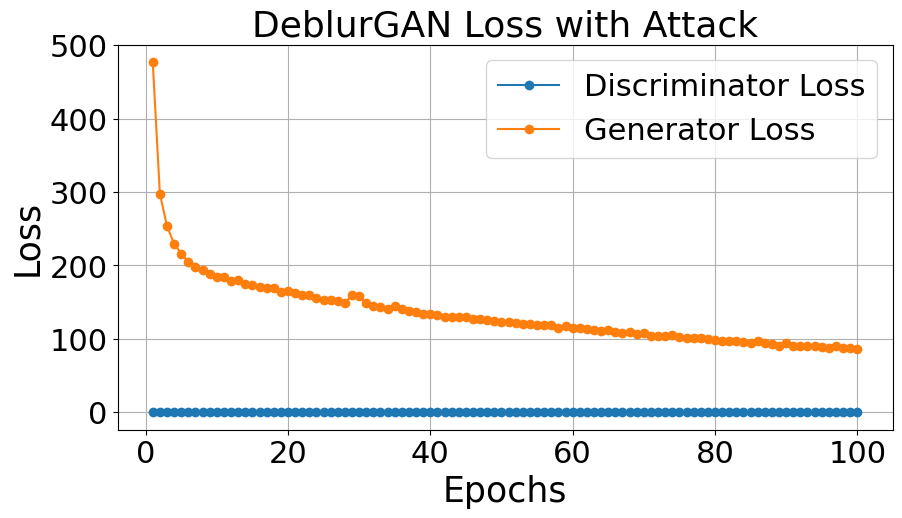

In [ ]:

import numpy as np
steps_per_epoch = 300

max_epoch = 100


plt.figure(figsize=(10, 5))

d_losses_m_100 = d_losses_m[:100]
g_losses_m_100 = g_losses_m[:100]

plt.plot(range(1, max_epoch + 1), d_losses_m_100, label="Discriminator Loss", marker='o')
plt.plot(range(1, max_epoch + 1), g_losses_m_100, label="Generator Loss", marker='o')


plt.xlabel("Epochs", fontsize=25)
plt.ylabel("Loss", fontsize=25)
plt.title("DeblurGAN Loss with Attack", fontsize=26)
plt.legend(fontsize=22)

plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=22)

plt.savefig("loss_plot.png")

plt.show()



In [ ]:
# # Plot losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), d_losses, label="D Loss", marker='o')
# plt.plot(range(1, epochs + 1), g_losses, label="G Loss", marker='o')

# # Increase font size for labels, title, and legend
# plt.xlabel("Epochs", fontsize=32)
# plt.ylabel("Loss", fontsize=32)
# plt.title("Discriminator and Generator Loss", fontsize=34)
# plt.legend(fontsize=22)
# plt.grid(True)

# plt.tick_params(axis='both', which='major', labelsize=23)

# # Save and show the plot
# plt.savefig("loss_plot.png")
# plt.show()
